### Set up Google Colab Environment

In [ ]:
!pip install transformers datasets accelerate


###  Load Pretrained Model and Tokenizer

In [1]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
#loading a model class that is already built on top of PyTorch (torch.nn.Module).

model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2) #because it is a binary classification
#PyTorch model under the hood, so can use any PyTorch functions on it.



tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Freeze All Layers Except the Classifier

Key Features of torch.nn.Module:

It stores model layers

It defines a forward() method (how data flows through the model)

It keeps track of parameters (weights & biases) with model.parameters() or model.named_parameters()

It handles things like saving, loading, GPU/CPU switching, etc.

In [2]:
# Freeze all parameters
for param in model.base_model.parameters():
    param.requires_grad = False

# Print to verify
for name, param in model.named_parameters():
    print(name, param.requires_grad)


distilbert.embeddings.word_embeddings.weight False
distilbert.embeddings.position_embeddings.weight False
distilbert.embeddings.LayerNorm.weight False
distilbert.embeddings.LayerNorm.bias False
distilbert.transformer.layer.0.attention.q_lin.weight False
distilbert.transformer.layer.0.attention.q_lin.bias False
distilbert.transformer.layer.0.attention.k_lin.weight False
distilbert.transformer.layer.0.attention.k_lin.bias False
distilbert.transformer.layer.0.attention.v_lin.weight False
distilbert.transformer.layer.0.attention.v_lin.bias False
distilbert.transformer.layer.0.attention.out_lin.weight False
distilbert.transformer.layer.0.attention.out_lin.bias False
distilbert.transformer.layer.0.sa_layer_norm.weight False
distilbert.transformer.layer.0.sa_layer_norm.bias False
distilbert.transformer.layer.0.ffn.lin1.weight False
distilbert.transformer.layer.0.ffn.lin1.bias False
distilbert.transformer.layer.0.ffn.lin2.weight False
distilbert.transformer.layer.0.ffn.lin2.bias False
distilbe

### Load the Dataset

In [3]:
!pip install --upgrade datasets fsspec

# datasets: The Hugging Face library for loading and processing datasets.

# fsspec: A file system interface used internally to load datasets from URLs, ZIPs, cloud, etc.

#This ensures we are using the latest versions to avoid compatibility bugs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 20.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; pla

In [4]:
# Clear the datasets cache to force a fresh download
!rm -rf ~/.cache/huggingface/datasets/*

from datasets import load_dataset

dataset = load_dataset("yelp_polarity") #This downloads the Yelp Polarity dataset.

# It is a sentiment classification dataset: 2 labels: 1 = Positive, 0 = Negative
# Texts = Yelp reviews


small_train = dataset["train"].shuffle(seed=42).select(range(2000))
small_test = dataset["test"].shuffle(seed=42).select(range(500))

# shuffle(seed=42): Randomizes the data (but reproducibly using the same seed).
# select(range(...)): Selects a small subset for faster training/testing in Colab.


import pandas as pd

df = pd.DataFrame(dataset["train"][:10])  # First 5 samples
df


README.md:   0%|          | 0.00/8.93k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/256M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/17.7M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/560000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/38000 [00:00<?, ? examples/s]

,text,label
0,"Unfortunately, the frustration of being Dr. Go...",0
1,Been going to Dr. Goldberg for over 10 years. ...,1
2,I don't know what Dr. Goldberg was like before...,0
3,I'm writing this review to give you a heads up...,0
4,All the food is great here. But the best thing...,1
5,Wing sauce is like water. Pretty much a lot of...,0
6,Owning a driving range inside the city limits ...,0
7,This place is absolute garbage... Half of the...,0
8,Before I finally made it over to this range I ...,1
9,I drove by yesterday to get a sneak peak. It ...,1


###  Tokenize the Dataset

In [5]:
def preprocess(examples):
    return tokenizer(examples["text"], truncation=True, padding=True)

#This takes a batch of text reviews (from examples["text"]) and converts them into tokenized input using the model’s tokenizer.
#Converts words into input IDs (numbers the model understands)
#Adds special tokens (like [CLS], [SEP])
#Applies truncation (cuts off long reviews)
#Adds padding (makes all sequences the same length)

encoded_train = small_train.map(preprocess, batched=True)
encoded_test = small_test.map(preprocess, batched=True)

#map(...) applies the preprocess() function to the entire dataset.
#batched=True tells it to process in batches for speed (instead of one-by-one).

#encoded_train and encoded_test contain:

#input_ids: tokenized version of each review
#attention_mask: tells the model which tokens are real vs. padding
#label: same as before


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

### Fine-tune Only Last Layer

In [6]:
import os
os.environ["WANDB_DISABLED"] = "true"

#Do not use Weights & Biases (W&B) logging for this run.

In [7]:
from transformers import TrainingArguments, Trainer
import numpy as np
!pip install evaluate # Explicitly install the evaluate library
import evaluate

#Trainer: high-level class to handle training, evaluation, logging, etc.
#evaluate: library used to calculate metrics like accuracy, F1, etc.

import evaluate

accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")

def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)  # Get predicted class
    acc = accuracy.compute(predictions=preds, references=p.label_ids) # Compare to true labels
    f1_score = f1.compute(predictions=preds, references=p.label_ids, average="weighted") #average="weighted" is useful when class balance isn't equal — it weighs F1 by class size.
    return {
        "accuracy": acc["accuracy"],
        "f1": f1_score["f1"]
    }

#This tells the trainer how to calculate accuracy after each evaluation.

training_args = TrainingArguments(
    output_dir="./results", # Where to save model files
    per_device_train_batch_size=8, # Batch size for training
    per_device_eval_batch_size=8, # Batch size for evaluation
    num_train_epochs=3, # Train for 3 full passes over the data
    # Changed evaluation_strategy to eval_strategy
    eval_strategy="epoch", # Evaluate after every epoch
    logging_steps=10, # Log training loss every 10 steps
    save_strategy="no" # Don’t save checkpoints
)
# telling the Trainer how to run the training loop.

trainer = Trainer(
    model=model, # The model I am fine-tuning
    args=training_args, # The training configuration
    train_dataset=encoded_train, # Training data
    eval_dataset=encoded_test, # Evaluation data
    compute_metrics=compute_metrics, # Function to calculate accuracy
)

trainer.train()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.3 MB/s eta 0:00:00


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.513000,0.499993,0.848000,0.847766
2,0.427900,0.402417,0.872000,0.871803
3,0.464000,0.382170,0.868000,0.867956


TrainOutput(global_step=750, training_loss=0.4943971761067708, metrics={'train_runtime': 32.376, 'train_samples_per_second': 185.322, 'train_steps_per_second': 23.165, 'total_flos': 794804391936000.0, 'train_loss': 0.4943971761067708, 'epoch': 3.0})

### Load New Model & Unfreeze Last Encoder Layer

In [8]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from collections import defaultdict

# Load a fresh model
model2 = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

# Freeze all layers
for param in model2.base_model.parameters():
    param.requires_grad = False

# Unfreeze only last encoder layer
for name, param in model2.named_parameters():
    if "transformer.layer.5" in name:
        param.requires_grad = True


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Set New TrainingArguments and Train Model 2

In [9]:
training_args2 = TrainingArguments(
    output_dir="./model_last_layer_unfrozen",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    eval_strategy="epoch",
    logging_dir="./logs2",
    logging_steps=10,
    save_strategy="no"
)

trainer2 = Trainer(
    model=model2,
    args=training_args2,
    train_dataset=encoded_train,
    eval_dataset=encoded_test,
    compute_metrics=compute_metrics,
)

trainer2.train()

# Save model and tokenizer
model2.save_pretrained("./model_last_layer_unfrozen")
tokenizer.save_pretrained("./model_last_layer_unfrozen")


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.163600,0.278053,0.902000,0.901798
2,0.263600,0.274376,0.906000,0.905921
3,0.252200,0.274611,0.922000,0.922005


('./model_last_layer_unfrozen/tokenizer_config.json',
 './model_last_layer_unfrozen/special_tokens_map.json',
 './model_last_layer_unfrozen/vocab.txt',
 './model_last_layer_unfrozen/added_tokens.json',
 './model_last_layer_unfrozen/tokenizer.json')

### Compare Both Training Runs (Plotting)

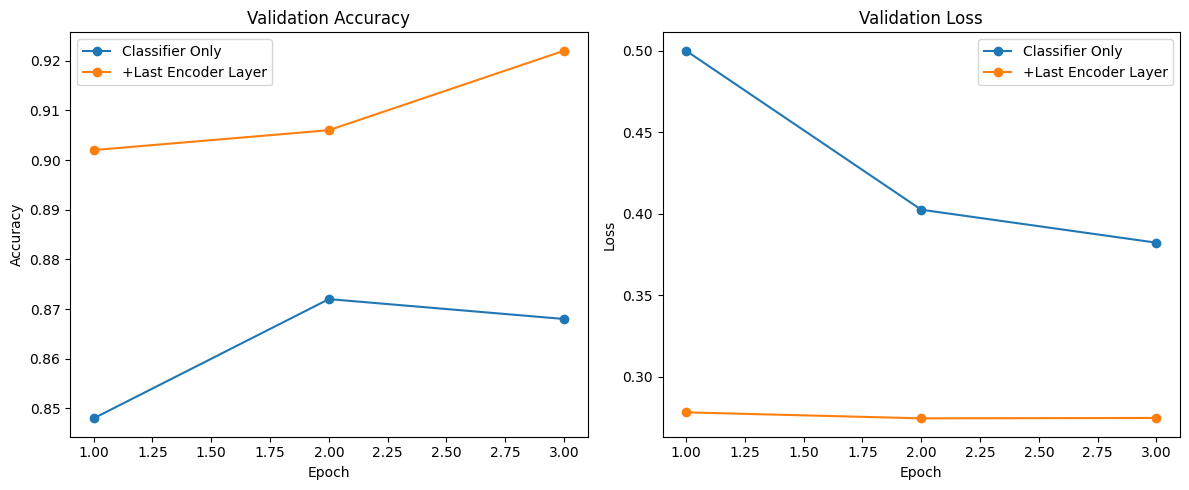

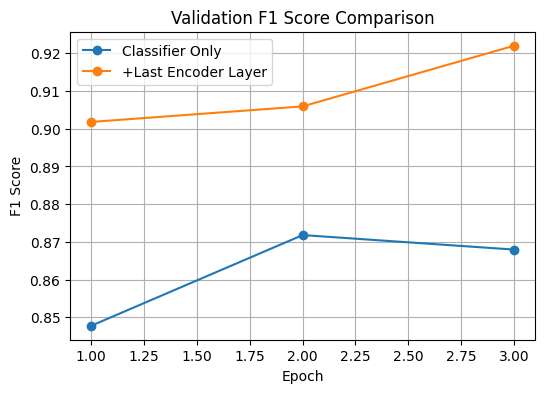

In [10]:
import matplotlib.pyplot as plt

# Use previous trainer (trainer1) and new trainer2
history1 = trainer.state.log_history
history2 = trainer2.state.log_history

# Helper to extract accuracy and loss
def extract_metrics(history):
    epochs, accs, losses = [], [], []
    for entry in history:
        if 'eval_accuracy' in entry:
            epochs.append(entry['epoch'])
            accs.append(entry['eval_accuracy'])
            losses.append(entry['eval_loss'])
    return epochs, accs, losses

epochs1, accs1, losses1 = extract_metrics(history1)
epochs2, accs2, losses2 = extract_metrics(history2)

# Plot comparison
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(epochs1, accs1, label='Classifier Only', marker='o')
plt.plot(epochs2, accs2, label='+Last Encoder Layer', marker='o')
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs1, losses1, label='Classifier Only', marker='o')
plt.plot(epochs2, losses2, label='+Last Encoder Layer', marker='o')
plt.title("Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()

# Extract F1 scores from training logs
def extract_f1(history):
    epochs, f1s = [], []
    for entry in history:
        if 'eval_f1' in entry:
            epochs.append(entry['epoch'])
            f1s.append(entry['eval_f1'])
    return epochs, f1s

f1_epochs1, f1s1 = extract_f1(history1)
f1_epochs2, f1s2 = extract_f1(history2)

# Plot F1 Score Comparison
plt.figure(figsize=(6,4))
plt.plot(f1_epochs1, f1s1, label='Classifier Only', marker='o')
plt.plot(f1_epochs2, f1s2, label='+Last Encoder Layer', marker='o')
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.title("Validation F1 Score Comparison")
plt.legend()
plt.grid(True)
plt.show()



### Observations

In this project, I fine-tuned a DistilBERT model on a sentiment classification task using two strategies:

(1) training only the final classification layer, and

(2) additionally unfreezing the last encoder layer.

The goal was to evaluate whether partial fine-tuning of the base model improves performance.


From the validation accuracy and loss plots, it is clear that Model 2 (with the last encoder layer unfrozen) consistently outperforms Model 1. It achieves higher validation accuracy (~92% vs. ~88%) and maintains lower, more stable loss across epochs. These improvements suggest that even limited unfreezing allows the model to better adapt to the downstream task.

The F1 score plot reinforces this conclusion — Model 2 shows consistently higher F1 scores across epochs (~92% vs. ~87%), indicating stronger balance between precision and recall. This means Model 2 not only predicts more accurately, but also more reliably across both classes, making it more robust for real-world applications.



### 🔍 Prediction Function: `predict_review()`

This function allows us to pass any text review into a fine-tuned DistilBERT model and receive a sentiment prediction along with a confidence score. It handles tokenization, device compatibility (CPU/GPU), and post-processing of the model output (logits to probabilities). The output includes the predicted label — either "Positive" or "Negative" — and a confidence score that reflects how sure the model is about its prediction. This function is especially useful for testing the model on custom inputs and comparing how different fine-tuning strategies affect prediction confidence.


In [11]:
import torch

def predict_review(text, model, tokenizer):
    # Tokenize the input text and return tensors in PyTorch format
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)

    #  Move the input tensors to the same device as the model (CPU or GPU)
    device = model.device
    inputs = {key: value.to(device) for key, value in inputs.items()}

    #  Run the model to get predictions
    outputs = model(**inputs)

    #  Convert raw logits to probabilities using softmax
    probs = outputs.logits.softmax(dim=1)

    #  Get the predicted class (0 or 1)
    pred = probs.argmax().item()

    #  Convert numerical label to human-readable text
    label = "Positive" if pred == 1 else "Negative"

    #  Get confidence score for the predicted label
    confidence = probs[0][pred].item()

    #  Return result as a dictionary
    return {
        "label": label,
        "confidence": round(confidence, 3)
    }



### 📊 Model Agreement and Performance Evaluation

In this section, we evaluate and compare the performance of the two fine-tuned models across the entire test set. We use the `predict_review()` function to generate predictions for all 500 test samples, and then compute how often the models agree on their predicted labels. In addition to agreement rate, we calculate each model's accuracy and F1 score using the true labels from the dataset. This gives us a quantitative understanding of how well each model performs overall, and whether unfreezing the last encoder layer leads to meaningful improvements in predictive accuracy and balance.


In [18]:
from sklearn.metrics import accuracy_score, f1_score

# Step 1: Get model predictions
def get_predictions(model, texts):
    preds = []
    for text in texts:
        result = predict_review(text, model, tokenizer)
        preds.append(result["label"])
    return preds

# Step 2: Collect predictions on all test samples
texts = small_test["text"]
true_labels = ["Positive" if label == 1 else "Negative" for label in small_test["label"]]

preds1 = get_predictions(model, texts)
preds2 = get_predictions(model2, texts)

# Step 3: Compare agreement
agree_count = sum(p1 == p2 for p1, p2 in zip(preds1, preds2))
total = len(texts)
print(f"Models agreed on {agree_count}/{total} reviews ({agree_count / total * 100:.2f}%)")

# Step 4: Compute individual performance
# Agreement summary
print(f"Models agreed on {agree_count}/{total} reviews ({agree_count / total * 100:.2f}%)")

# Model 1 performance
acc1 = accuracy_score(true_labels, preds1)
f1_1 = f1_score(true_labels, preds1, pos_label="Positive")

# Model 2 performance
acc2 = accuracy_score(true_labels, preds2)
f1_2 = f1_score(true_labels, preds2, pos_label="Positive")

print("\n📊 Model 1 (Classifier Only):")
print(f"Accuracy: {round(acc1, 2)}")
print(f"F1 Score: {round(f1_1, 2)}")

print("\n📊 Model 2 (+Last Encoder Layer):")
print(f"Accuracy: {round(acc2, 2)}")
print(f"F1 Score: {round(f1_2, 2)}")

Models agreed on 453/500 reviews (90.60%)
Models agreed on 453/500 reviews (90.60%)

📊 Model 1 (Classifier Only):
Accuracy: 0.87
F1 Score: 0.86

📊 Model 2 (+Last Encoder Layer):
Accuracy: 0.92
F1 Score: 0.92
